In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
import numpy as np

In [2]:
# important variables

xmin = 3750901.5068
xmax = 3770901.5068
ymin = -19268905.6133
ymax = -19208905.6133
xavg = (xmax+xmin)/2
yavg = (ymax+ymin)/2
xminnorm = xmin-xavg
xmaxnorm = xmax-xavg
yminnorm = ymin-yavg
ymaxnorm = ymax-yavg

## Data Loading

In [3]:
import pylab
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_train_df = pd.read_csv('train_supernorm.csv')

data_test_df = pd.read_csv('test_supernorm.csv')

with open('train_label.json', 'r') as infile:
    target_train_df = pd.DataFrame(json.load(infile), columns=['target'])

In [5]:
data_train_dl_df = pd.read_csv('train_dl.csv')

data_test_dl_df = pd.read_csv('test_dl.csv')

In [6]:
data_train_df = pd.concat([data_train_df, data_train_dl_df], axis=1)

data_test_df = pd.concat([data_test_df, data_test_dl_df], axis=1)

In [17]:
# daf = pd.DataFrame()
# daf['value'] = [x%3 for x in range(0,100)]
# daf00 = daf[daf['value'] == 0]
# idx0 = daf00.index
# idx1 = daf[daf['value'] > 0].index
# daf0 = daf.iloc[idx0]
# daf1 = daf.iloc[idx1]

# dafcon = pd.concat([daf0, daf1], axis=0).sort_index()
# daf00['addition'] = [x for x in range(1,35)]

In [5]:
data_train_df.head()

id  prev_iscitycenter  \
0    traj_0000a8602cf2def930488dee7cdad104_1_5                  0   
1    traj_0000cf177130469eeac79f67b6bcf3df_9_3                  0   
2    traj_0001f97b99a80f18f62e2d44e54ef33d_3_1                  0   
3  traj_0002124248b0ca510dea42824723ccac_31_10                  0   
4  traj_000219c2a6380c307e8bffd85b5e404b_23_16                  0   

   prev_normalizedx  prev_normalizedy  mid_iscitycenter  mid_normalizedx  \
0     -15956.876032     -42928.234105                 0    -16086.006642   
1     -11813.564585     -27144.716431                 0    -11811.338195   
2      -2163.277928    -137034.585072                 0     -3897.635595   
3       6964.920317      60940.232815                 1      2977.456157   
4     -13260.717965      11951.552062                 0    -13412.112473   

   mid_normalizedy  mid_entrytime  first_iscitycenter  first_normalizedx  ...  \
0    -53935.540259        29005.0                   0       -9887.737394  ...   
1    -28357.454016        52789.0                   0      -11451.776240  ...   
2    -58072.470057        42728.0                   0       10559.426675  ...   
3     23992.711538        50956.0                   0        4642.795739  ...   
4      9096.980601         2462.0                   1        -565.843235  ...   

   active_distance  active_avgspeed  active_minspeed  active_maxspeed  \
0     47884.742155        20.684554         1.223708       175.787814   
1         0.000000         0.000000         0.000000         0.000000   
2    193384.920615       214.395699       214.395699       214.395699   
3     36327.663368        28.336711         0.096098        31.199591   
4     71910.819801        19.685415         2.376598        76.680064   

   inactive_longestduration  inactive_longestdurationendtime  prev_relativex  \
0                   25471.0                          25471.0              -1   
1                   52163.0                          52163.0              -1   
2                   41826.0                          41826.0               0   
3                   35768.0                          35768.0               0   
4                   18913.0                          21375.0              -1   

   prev_relativey  prev_ccdeltax  prev_ccdeltay  
0              -1    5956.876032   12928.234105  
1               0    1813.564585    2855.283569  
2              -1    7836.722072  107034.585072  
3               1    3035.079683   30940.232815  
4               0    3260.717965   18048.447938  

[5 rows x 29 columns]

In [7]:
def show_heatmap(df):
    corr = df.corr()
    fig, ax = pylab.subplots(figsize=(20, 20))
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True)

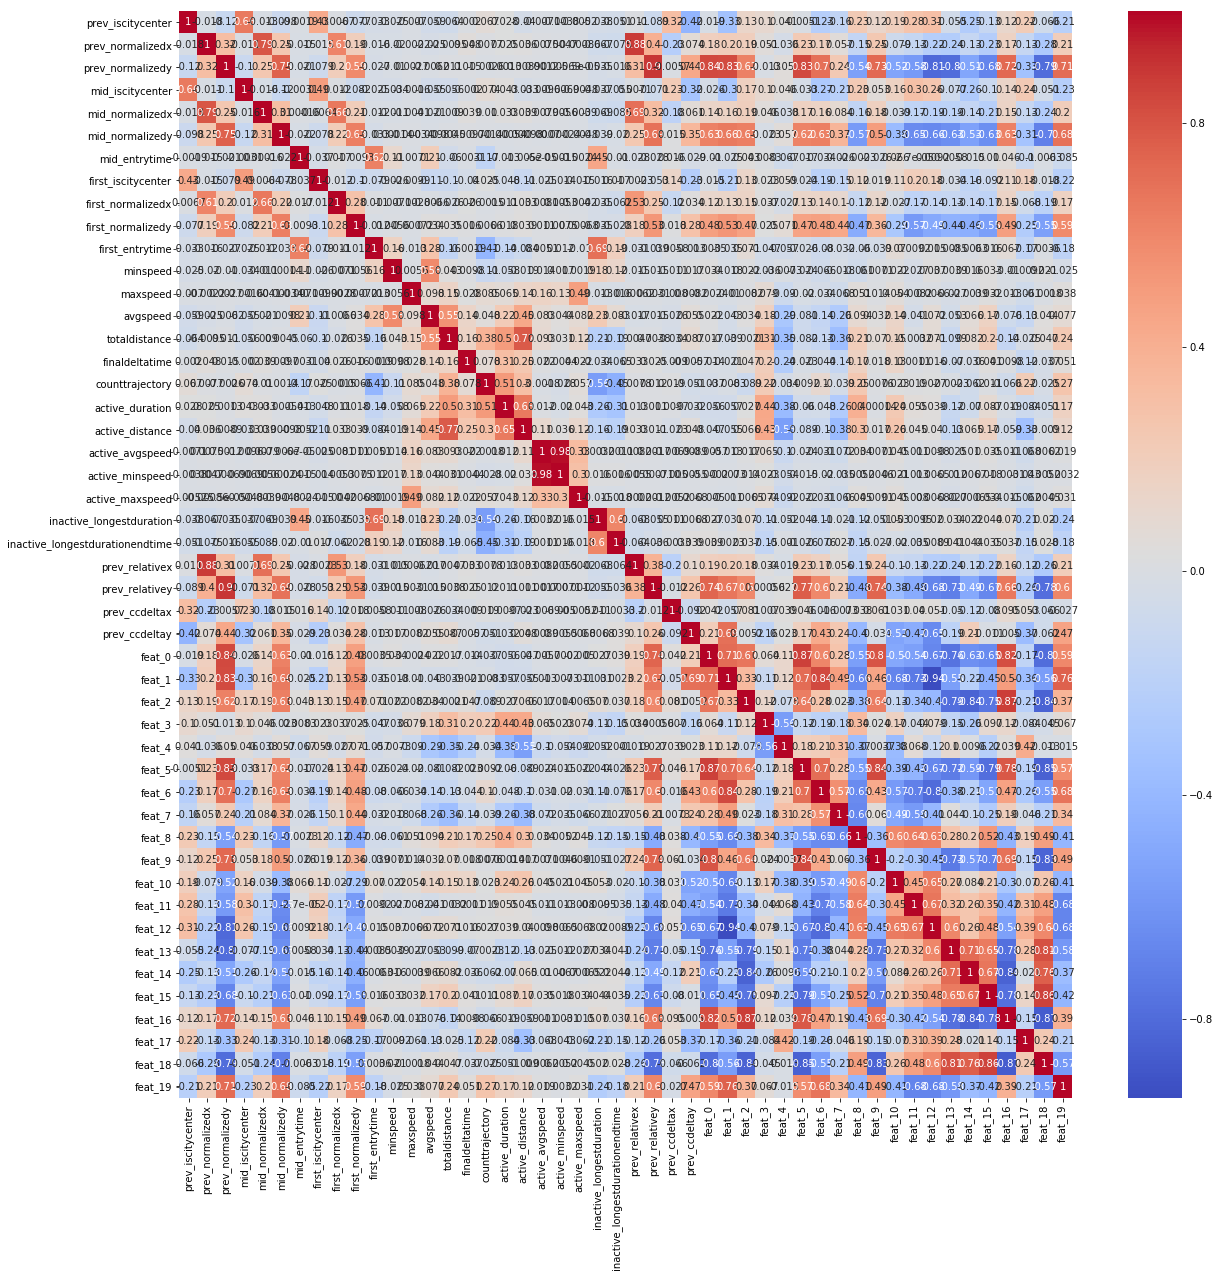

In [8]:
show_heatmap(data_train_df)

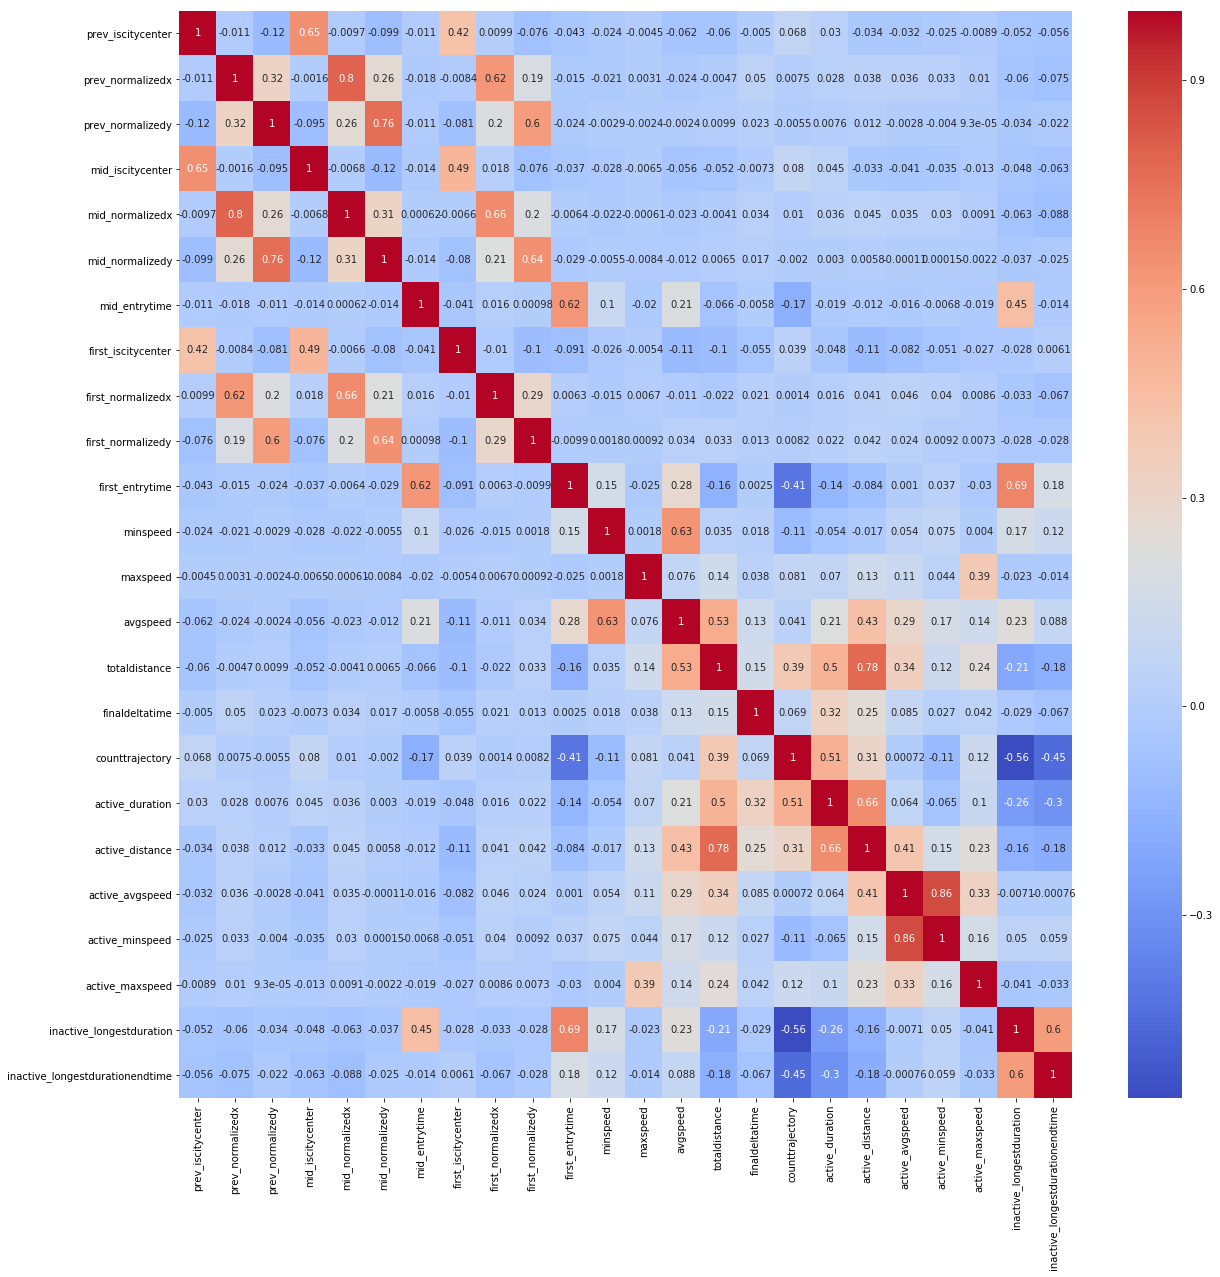

In [11]:
show_heatmap(data_test_df)

## Train

In [7]:
from sklearn.model_selection import KFold
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from lightgbm import LGBMClassifier

from model import DiffClassifier, SplitClassifier, LGBMCustomClassifier

In [8]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [9]:
tbd = ['id',
       'active_maxspeed', 'active_minspeed',
       'inactive_longestduration', 'inactive_longestdurationendtime',
       'mid_iscitycenter', 'mid_normalizedx', 'mid_normalizedy', 'mid_entrytime',
       'prev_relativex', 'prev_relativey', 
       'prev_ccdeltax', 'prev_ccdeltay'
      ]

In [10]:
data_train_df.drop(tbd, 1, inplace=True)

In [11]:
# data_train_df = data_train_df[data_train_df['finaldeltatime'] != 0]
# target_train_df = target_train_df.iloc[data_train_df.index.values.tolist()]

In [12]:
n_iter = 1
n_splits = 5

def run_kfold(model):
    avg = 0
    avg_train = 0
    for i in range(0,n_iter):
        kf = KFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in kf.split(data_train_df):
            data_train, data_test = data_train_df.iloc[train_index], data_train_df.iloc[test_index]
            target_train, target_test = target_train_df.iloc[train_index], target_train_df.iloc[test_index]
            model.fit(data_train, target_train)
            pred = model.predict(data_test)
            model.fit(data_train, target_train)
            pred_train = model.predict(data_train)
            avg = avg + f1_score(target_test, pred)
            avg_train = avg_train + f1_score(target_train, pred_train)
            print("F1 = " + str(f1_score(target_test, pred)) + " , " + str(f1_score(target_train, pred_train)))
            print("P = " + str(precision_score(target_test, pred)) + " , " + str(precision_score(target_train, pred_train)))
            print("R = " + str(recall_score(target_test, pred)) + " , " + str(recall_score(target_train, pred_train)))
    avg = avg/(n_iter * n_splits)
    avg_train = avg_train/(n_iter * n_splits)
    print("Average = " + str(avg) + " , " + str(avg_train))

def run_kfold_xgboost(model):
    avg = 0
    avg_train = 0
    for i in range(0,n_iter):
        kf = KFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in kf.split(data_train_df):
            data_train, data_test = data_train_df.iloc[train_index], data_train_df.iloc[test_index]
            target_train, target_test = target_train_df.iloc[train_index], target_train_df.iloc[test_index]
            classcnt = target_train.groupby('target')['target'].count()
            weight = [(classcnt.sum()/classcnt[x] + 2.0*2.0)/3.0 for x in target_train['target']]
            model.fit(data_train, target_train, sample_weight=weight)
            pred = model.predict(data_test)
            model.fit(data_train, target_train, sample_weight=weight)
            pred_train = model.predict(data_train)
            avg = avg + f1_score(target_test, pred)
            avg_train = avg_train + f1_score(target_train, pred_train)
            print("F1 = " + str(f1_score(target_test, pred)) + " , " + str(f1_score(target_train, pred_train)))
            print("P = " + str(precision_score(target_test, pred)) + " , " + str(precision_score(target_train, pred_train)))
            print("R = " + str(recall_score(target_test, pred)) + " , " + str(recall_score(target_train, pred_train)))
    avg = avg/(n_iter * n_splits)
    avg_train = avg_train/(n_iter * n_splits)
    print("Average = " + str(avg) + " , " + str(avg_train))


# sample_weight=weight
# eval_metric=f1_eval

In [46]:
# xg = XGBClassifier(max_depth=8, n_estimators=200)

# xg = RandomForestClassifier(max_depth=8, n_estimators=200)

# xg = DiffClassifier()

# xg = LGBMClassifier(n_estimators=200, max_depth=8)

# xg = SplitClassifier()

xg = LGBMClassifier(n_estimators=200, max_depth=8)
xg = BaggingClassifier(xg, )

# xg = LGBMCustomClassifier(proba_threshold=0.5)

run_kfold_xgboost(xg)

F1 = 0.8872901678657075 , 0.9188656747368967
P = 0.8965660481860981 , 0.9212058212058212
R = 0.8782042587820426 , 0.9165373875271486
F1 = 0.8855216514909293 , 0.9191509822777854
P = 0.8930323846908734 , 0.9194667766096337
R = 0.8781362007168458 , 0.9188354047929684
F1 = 0.8944047701587741 , 0.9171143250688704
P = 0.9032348410586752 , 0.9189496929128425
R = 0.8857456742653117 , 0.9152862739707196
F1 = 0.8901710282299609 , 0.9167513564723108
P = 0.8915795266923501 , 0.9186977836083684
R = 0.8887669729803868 , 0.9148131596135997
F1 = 0.8935665992890499 , 0.9177056500085866
P = 0.8943770057206641 , 0.920392697209783
R = 0.8927576601671309 , 0.9150342465753425
Average = 0.8901908434068844 , 0.9179175977128899


## Predict

In [14]:
ids = data_test_df['id']
data_test_df.drop(tbd, 1, inplace=True)

In [18]:
xg = LGBMClassifier(n_estimators=200, max_depth=8)
classcnt = target_train_df.groupby('target')['target'].count()
weight = [(classcnt.sum()/classcnt[x] + 2.0*2.0)/3.0 for x in target_train_df['target']]
xg.fit(data_train_df, target_train_df, sample_weight=weight)
pred = xg.predict(data_test_df)

In [19]:
xg.feature_importances_

array([ 72,  84, 222,  67, 194, 156, 194, 172, 139, 139, 163, 626,  65,
       109,  91, 144, 162, 157,  94,  75,  55,  59, 109,  95, 104, 130,
       137,  87,  96, 101,  88,  74, 125, 113, 108,  87, 120,  82, 115,
       112,  82,  85, 143, 124,  92, 135, 113, 104])

In [21]:
xg.importance_type

'split'

In [16]:
result = pd.DataFrame()
result['id'] = ids
result['target'] = pred

In [17]:
result.to_csv('feat40d1s_lstm1_lgbm3_customweight2_bag10.csv', index=False)

In [27]:
pred = pd.read_csv('submission/feat16_classbalancing.csv')['target']

In [27]:
xg.predict_proba(data_test_df)

array([[-1.46160672e-02, -4.23293300e+00],
       [-3.75047938e-03, -5.58774627e+00],
       [-5.82627020e+00, -2.95341292e-03],
       ...,
       [-1.22432653e-03, -6.70597646e+00],
       [-1.79318275e-02, -4.03013059e+00],
       [-3.31365802e-04, -8.01245333e+00]])

In [45]:
print([x[1] for x in xg.predict_proba(data_test_df) if x[1]>0.4 and x[1]<0.6])

[0.46892506, 0.47990763, 0.408091, 0.4954564, 0.53966814, 0.4837901, 0.42714468, 0.5778127, 0.41871038, 0.55333203, 0.502979, 0.53361005, 0.49798185, 0.47417462, 0.54315525, 0.54663575, 0.4247042, 0.50299734, 0.5434949, 0.5535878, 0.46271804, 0.44011703, 0.4768384, 0.41800246, 0.46062925, 0.421341, 0.4011985, 0.5213759, 0.56887805, 0.53426677, 0.53119797, 0.40982687, 0.5739587, 0.45383763, 0.5067928, 0.58028316, 0.44620383, 0.5578374, 0.53634715, 0.496107, 0.46786562, 0.47942126, 0.5260835, 0.5332073, 0.47931352, 0.5949704, 0.5119891, 0.5228993, 0.42599645, 0.44119063, 0.59931934, 0.48264068, 0.5909921, 0.53783, 0.59146327, 0.5034344, 0.5651365, 0.4945232, 0.5668836, 0.48884764, 0.4720786, 0.41549072, 0.40168417, 0.4847503, 0.45731473, 0.4771993, 0.5947413, 0.4317065, 0.45070305, 0.4917229, 0.47799557, 0.54245234, 0.56149924, 0.57257444, 0.59252095, 0.41455925, 0.49343413, 0.512883, 0.4413739, 0.43892062, 0.4262091, 0.5859796, 0.42775154, 0.58727753, 0.40438038, 0.5278974, 0.59847397, 

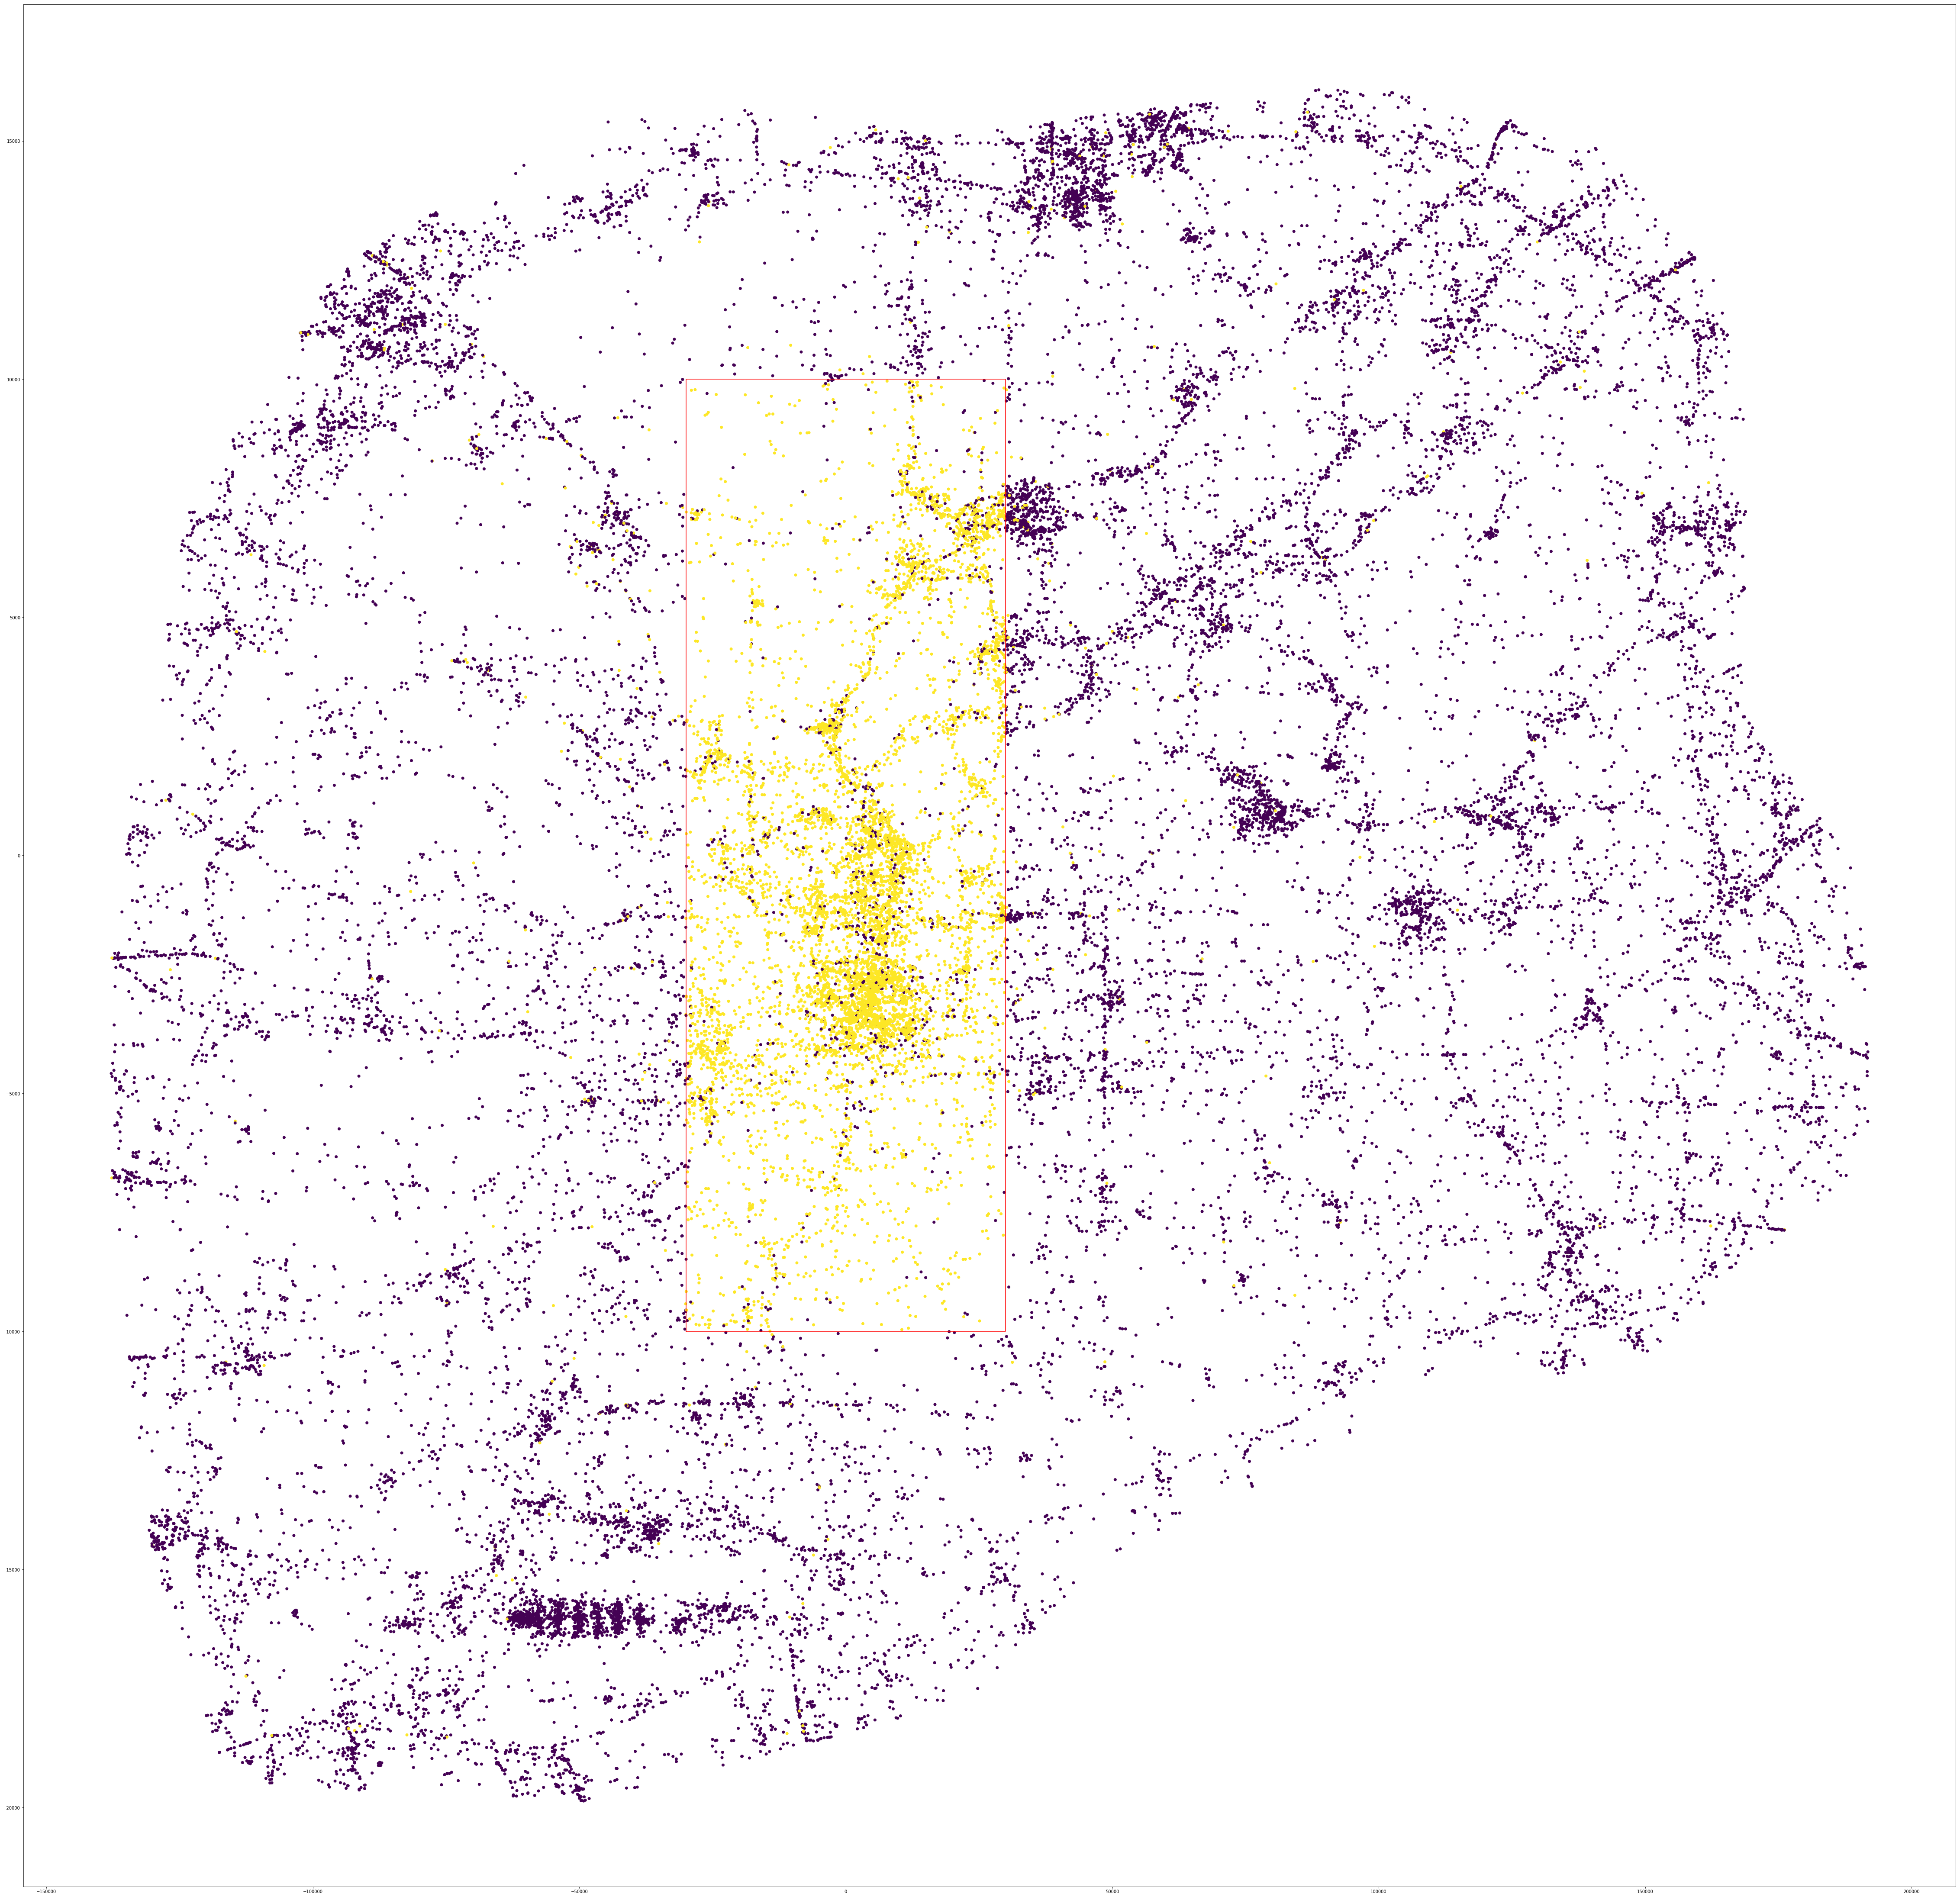

In [22]:
fig, ax = pylab.subplots(figsize=(80,80))
ax.scatter(data_test_df['prev_normalizedy'], data_test_df['prev_normalizedx'], c=pred)
pylab.plot([yminnorm, ymaxnorm, ymaxnorm, yminnorm, yminnorm], [xminnorm, xminnorm, xmaxnorm, xmaxnorm, xminnorm], 'red')